# Task Description

https://www.kaggle.com/datasets/andrewmvd/animal-faces

Develop a custom neural network to classify images of animal faces into their respective categories.

# Initial Setup

In [4]:
import numpy as np
import pandas as pd
import torch

import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.notebook import tqdm
import os, glob

from PIL import Image
from torchvision import datasets, transforms
from keras.preprocessing.image import img_to_array
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from torchvision import models
import torchinfo
import torch.optim as optim

import warnings
warnings.filterwarnings('ignore')

import time

# Exploratory Data Analysis

In [25]:
# path = 'drive/MyDrive/Colab Notebooks/dataset'
path = 'dataset'
subfolders = os.listdir(f'{path}')
for subfolder in subfolders:
    categories = os.listdir(f'{path}/{subfolder}')
    total_num = 0
    print(f'{subfolder}')
    for category in categories:
        file_paths = glob.glob(f'{path}/{subfolder}/{category}/*.jpg')
        category_num = len(file_paths)
        print(f"{category}: {category_num} pictures.")
        total_num += category_num
    print(f'Total number of {subfolder} pictures: {total_num}.')
    print('-'*40)


train
cat: 5153 pictures.
dog: 4739 pictures.
wild: 4738 pictures.
Total number of train pictures: 14630.
----------------------------------------
val
cat: 500 pictures.
dog: 500 pictures.
wild: 500 pictures.
Total number of val pictures: 1500.
----------------------------------------


There is a total of 16130 pictures in the dataset out of which 14630 are in the train part, and 1500 in the test part. Three classes ('cat', 'dog' and 'wild') are balanced.

In [26]:
# Label encoding
categories = dict(enumerate(categories))
print(categories)

{0: 'cat', 1: 'dog', 2: 'wild'}


cat example:


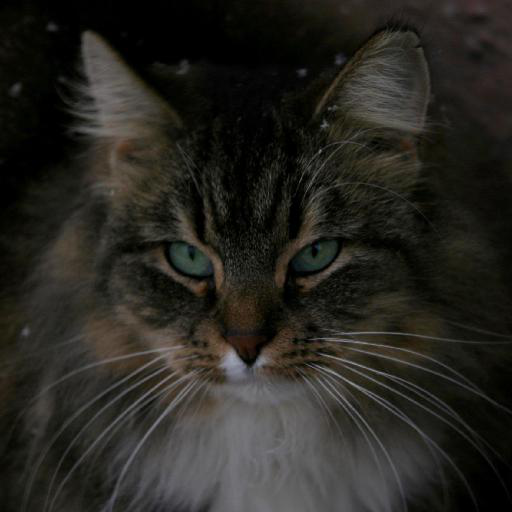

dog example:


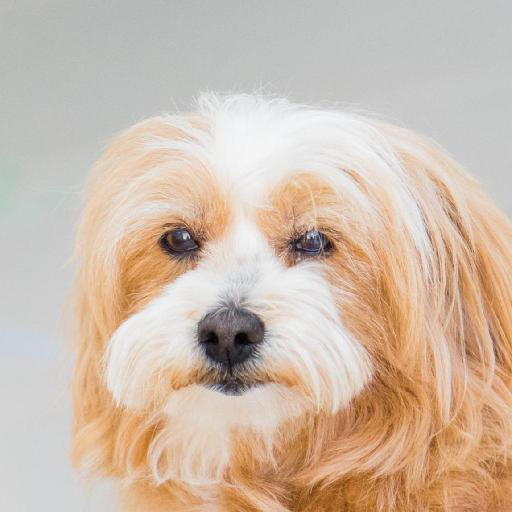

wild example:


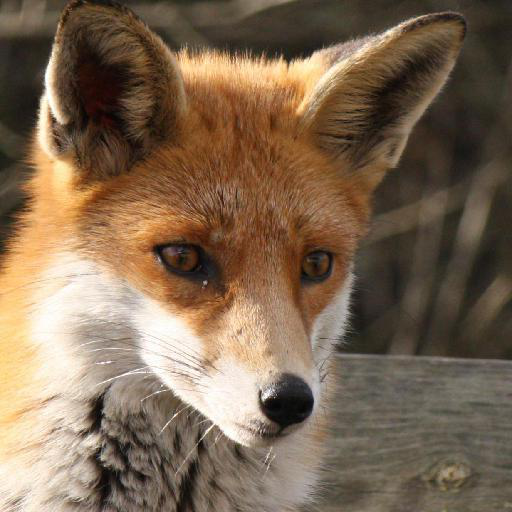

In [5]:
for category in categories:
    file_paths = glob.glob(f'{path}/{subfolders[0]}/{categories[category]}/*.jpg')
    print(f'{categories[category]} example:')
    display(Image.open(file_paths[0]))

In [6]:
file_path = glob.glob(f'{path}/{subfolders[0]}/{categories[0]}/*.jpg')[0]
img = np.asarray(Image.open(file_path))
img.shape

(512, 512, 3)

All pictures are coloured and have the size of 512*512 pixels which probably should be downscaled later.

# Custom Neural Network

First of all, let us write our own simple neural network and iterate through some of its parameters:
1. 'resolution' - size of pictures after resizing in pixels,
2. 'batch_size' - batch size,
3. 'auto_augment' - enables/disables auto augmentation of pictures,
4. 'optimizer' - selects optimiser,
5. 'learning_rate' - learning rate,
6. 'n_epochs' - number of epochs,
7. 'activation' - activation function,
8. 'batch_norm' - enables/disables batch normalisation,
9. 'n_max_pooling' - number of times max pooling is used,
10. 'n_convol_layers_for_each_max_pool' - number of convolutional layers preceeeding each max pooling.

In [1]:
!nvidia-smi

Fri Mar  7 18:41:12 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 572.16                 Driver Version: 572.16         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4050 ...  WDDM  |   00000000:01:00.0  On |                  N/A |
| N/A   40C    P8              4W /   95W |     421MiB /   6141MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Wed_Feb__8_05:53:42_Coordinated_Universal_Time_2023
Cuda compilation tools, release 12.1, V12.1.66
Build cuda_12.1.r12.1/compiler.32415258_0


In [5]:
torch.cuda.is_available()

True

In [6]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [14]:
# Setting the seed for reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)  # PyTorch CPU
    torch.cuda.manual_seed(seed)  # PyTorch GPU (if using CUDA)
    torch.cuda.manual_seed_all(seed)  # If using multi-GPU
    np.random.seed(seed)  # NumPy
    torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior
    torch.backends.cudnn.benchmark = False  # Disable auto-optimization for reproducibility

set_seed(42)

The structure of the neural network is as follows:

![PrimitiveNN_structure.JPG](https://raw.githubusercontent.com/Boris-R1/portfolio/main/4_Animal_face_classification/PrimitiveNN_structure.JPG)

1 is repeated n_convol_layers_for_each_max_pool times.

I is repeated n_max_pooling times.

II is repeated twice.

In [35]:
class Flatten(nn.Module):
    '''
    An auxiliary class for flattening 2D-array of a picture
    '''
    def forward(self, input):
        return input.view(input.size(0), -1)


class PrimitiveNN(nn.Module):
    '''
    Neural network itself
    '''
    def __init__ (self):
        super().__init__()
        self.flatten = Flatten()

        # Accessing global variables with parameters because I didn't manage to pass them to the PrimitiveNN class
        # (maybe there is a way to do it somehow?)
        global current_params_for_nn
        self._n_max_pooling = current_params_for_nn['n_max_pooling']
        self._n_convol_layers_for_each_max_pool = current_params_for_nn['n_convol_layers_for_each_max_pool']
        self._batch_norm = current_params_for_nn['batch_norm']
        self._resolution = current_params_for_nn['resolution']
        self._activation = current_params_for_nn['activation']

        # Creating convolution layers with the number of out_channels equal to
        # 8, 16, 32, 64, etc and default kernel size followed by Dropout,
        #  activation layer with the passed activation function, and max pooling.
        # Batch normalisation is performed after each convolution if it is switched on
        self.sequential_list = []
        in_channels = 3 # Three channels for coloured pictures
        # For each max pooling layer
        for n_pool in range(self._n_max_pooling):
            self.sequence = []
            # For each convolution layer in each max pooling layer
            for i in range(self._n_convol_layers_for_each_max_pool):
                if in_channels == 3:
                    out_channels = 8
                else:
                    out_channels = in_channels * 2
                self.sequence.append(nn.Conv2d(in_channels, out_channels, kernel_size=3))

                # Batch normalisation after each convolution if necessarry
                if self._batch_norm:
                    self.sequence.append(nn.BatchNorm2d(out_channels))
                in_channels = out_channels
            self.sequence.append(nn.Dropout(0.2))
            self.sequence.append(self._activation())
            self.sequence.append(nn.MaxPool2d(kernel_size=2))

            # As a result obtained a list with several nn.Sequential objects incorporating
            # layers with convolution, dropout, activation, and max pooling
            self.sequential_list.append(nn.Sequential(*self.sequence).to(device))

        # Compute final feature size
        dummy_input = torch.zeros(1, 3, self._resolution, self._resolution, device=device)
        with torch.no_grad():
            for seq in self.sequential_list:
                dummy_input = seq(dummy_input)
            flattened_size = dummy_input.view(1, -1).size(1)  # Get feature size after flattening

        # Several fully connected layers
        self.sequential_last = nn.Sequential(
                             nn.Linear(in_features=flattened_size, out_features=100),
                             nn.Linear(in_features=100, out_features=3))

        self.init_weights()

    # He initialisation of weights
    def init_weights(self):
        for seq in self.sequential_list:
            torch.nn.init.kaiming_normal_(seq[0].weight, a=0.01, mode='fan_in', nonlinearity='leaky_relu')
            seq[0].weight = seq[0].weight.to(device)

    # Main part
    def forward(self, x):
        for sequence in self.sequential_list:
            x = sequence(x)
        x = self.flatten(x)
        x = self.sequential_last(x)
        return x



In [27]:
class NNWithAllParams():
    '''
    A class that performs training and testing on a neural network with a set of passed parameters.
    The initial idea was to put everything related to PrimitiveNN into it.
    '''
    def __init__(self,
                 resolution=128,
                 batch_size=32,
                 auto_augment=False,
                 optimizer=torch.optim.AdamW,
                 learning_rate=1e-3,
                 n_epochs=5,
                 activation=nn.LeakyReLU,
                 batch_norm=False,
                 n_max_pooling=2,
                 n_convol_layers_for_each_max_pool=2):

        self._resolution = resolution
        self._batch_size = batch_size
        self._auto_augment = auto_augment
        self._optimizer = optimizer
        self._learning_rate = learning_rate
        self._n_epochs = n_epochs

        self.prepare_pics()
        self.train()


    def prepare_pics(self):
        '''
        A method that resizes pics, augments them and splits into batches
        according to specified parameters.
        '''
        # Defining transfromation parameters
        transformations_list = [transforms.Resize((self._resolution, self._resolution))]
        if self._auto_augment:
            transformations_list.append(transforms.AutoAugment())
        transformations_list.append(transforms.ToTensor())
        transform = transforms.Compose(transformations_list)

        # Uploading pictures from the folder and transforming them
        train_data = datasets.ImageFolder(f"{path}/train/", transform=transform)
        test_data = datasets.ImageFolder(f"{path}/val/", transform=transform)

        # Splitting data into batches
        self._train_loader = torch.utils.data.DataLoader(train_data,
                                                         batch_size=self._batch_size,
                                                         shuffle = True,
                                                         pin_memory=True,
                                                         num_workers=2)
        self._test_loader = torch.utils.data.DataLoader(test_data,
                                                        batch_size=self._batch_size,
                                                        shuffle = False,
                                                        pin_memory=True)


    def show_pics_shape_and_examples(self, n=5):
        '''
        This method simply prints the shape of batches and displays several pictures from the train set after resizing.
        '''
        images, labels = next(iter(self._train_loader))
        print(f'Images shape: {images.shape}')
        print(f'Labels shape: {labels.shape}')

        if n > self._batch_size:
            n = self._batch_size
        fig, axes= plt.subplots(1, n, figsize=(30, 5))
        for i in range(n):
            axes[i].imshow(np.transpose(images[i].numpy(), (1, 2, 0)))
            axes[i].set_title(labels[i].numpy(), fontdict={'fontsize': 20});

    def train(self):
        '''
        A method to train and test neural network with current parameters
        '''
        
        torch.cuda.empty_cache()
        # Instantiating neural network
        net = PrimitiveNN().to(device)

        # Defining loss function
        loss_fn = torch.nn.CrossEntropyLoss()

        # Defining optimisation algorithm and initial learning rate
        if self._optimizer == torch.optim.AdamW:
            optimizer = self._optimizer(net.parameters(), lr=self._learning_rate)
        elif self._optimizer == torch.optim.Adadelta:
            optimizer = self._optimizer(net.parameters(), lr=self._learning_rate, rho=0.9, eps=1e-8)

        self._best_accuracy = 0
        self._best_number_of_epochs = 0
        self._best_precision = []
        self._best_recall = []
        self._best_f1 = []

        # Iterating through epochs
        for epoch in range(self._n_epochs):
            print('-'*40)
            print(f'Epoch {epoch} started.')
            print('Current batch: ', end='')
            train_dataiter = iter(self._train_loader)

            # Iterating through batches
            for i, batch in enumerate(train_dataiter):
                if i % 10 == 0:
                    print(f'{i} ', end='')
                # Obtaining current batch
                X_batch, y_batch = batch

                # Sending batch to GPU
                X_batch = X_batch.to(device, non_blocking=True)
                y_batch = y_batch.to(device, non_blocking=True)
                
                # Resetting gradients
                optimizer.zero_grad()

                # Forward. Calculating loss based on predicted target values for the batch
                y_pred = net(X_batch)
                loss = loss_fn(y_pred, y_batch)

                # Backward. Calculating gradients and updating weights
                loss.backward()
                optimizer.step()

            # Computing accuracy after each epoch
            with torch.no_grad():
                accuracy = []
                all_labels = []
                all_preds = []
                for batch in self._test_loader:
                    x, y = batch
                    x = x.to(device)
                    y = y.to(device)

                    y_pred = net(x)
                    # Collecting true labels and predictions
                    all_labels.extend(y.detach().cpu().numpy())
                    all_preds.extend(np.argmax(y_pred.detach().cpu().numpy(), axis=1))

                # Calculating average accuracy for all test batches
                accuracy = np.mean(np.array([1 if a == b else 0 for a, b in zip(all_labels, all_preds)]))

                # Calculating precision, f1 and recall for each class
                precision = precision_score(all_labels, all_preds, average=None)
                recall = recall_score(all_labels, all_preds, average=None)
                f1 = f1_score(all_labels, all_preds, average=None)

                print()
                if accuracy > self._best_accuracy:
                    self._best_accuracy = round(accuracy, 3)
                    # Precision, recall and f1 for each class corresponding to the best accuracy
                    self._best_precision = list(map(lambda x: round(x, 3), precision))
                    self._best_recall = list(map(lambda x: round(x, 3), recall))
                    self._best_f1 = list(map(lambda x: round(x, 3), f1))
                    self._best_number_of_epochs = epoch + 1
                    print(f'Best accuracy obtained: {self._best_accuracy}. {epoch+1} epochs completed.')
                    print(f'Precision per class: {self._best_precision}')
                    print(f'Recall per class: {self._best_recall}')
                    print(f'F1 Score per class: {self._best_f1}')


    def get_metrics(self):
        return self._best_accuracy, self._best_precision, self._best_recall, self._best_f1, self._best_number_of_epochs


In [48]:
def param_grid_iterator(param_grid,
                       j = 0,
                       current_params = {}):
    '''
    A function iterating through all parameters for NN via recursion and running it for each combination.
    'j' is the number of a current parameter.
    '''
    global results, current_params_for_nn, current_combination
    if j == 0:
        current_params = {}

    # Iterating through all values of j-parameter and adding them to a dictionary
    for param in param_grid[list(param_grid.keys())[j]]:
        current_params[list(param_grid.keys())[j]] = param

        # Calling the function itself if there are more parameters to add
        if j < len(param_grid) - 1:
            param_grid_iterator(param_grid,
                               j = j + 1,
                               current_params = current_params)

        # If no more parameters left, instantiating NNWithAllParams with
        # the current set of parameters
        else:
            current_combination += 1
            print('-'*40)
            print('-'*40)
            print(f'Parameter combination {current_combination}/{n_combinations}.')
            current_params_for_nn = current_params.copy()
            nn_with_params_instance = NNWithAllParams(**current_params)
            best_accuracy, precision, recall, f1, best_number_of_epochs = nn_with_params_instance.get_metrics()

            # Saving results with the current params to the dataframe
            results_new_line = current_params.copy()
            results_new_line['n_epochs'] = best_number_of_epochs
            results_new_line['accuracy'] = best_accuracy
            results_new_line['precision'] = precision
            results_new_line['recall'] = recall
            results_new_line['f1'] = f1
            results_new_line = pd.DataFrame(data=[results_new_line])
            results = pd.concat([results, results_new_line], ignore_index=True)


In [7]:
# I am to iterate through several parameters
param_grid = {'resolution': [64, 32],
              'batch_size': [64],
              'auto_augment': [False, True],
              'optimizer': [torch.optim.AdamW, torch.optim.Adadelta],
              'learning_rate': [1e-3],
              'n_epochs': [5],
              'activation': [nn.SiLU, nn.LeakyReLU],
              'batch_norm': [False, True],
              'n_max_pooling': [2],
              'n_convol_layers_for_each_max_pool': [2]
             }


In [49]:
results = pd.DataFrame()
n_combinations = 1
for param in param_grid:
    n_combinations *= len(param_grid[param])
print(f'{n_combinations} parameter combinations in total.')
current_combination = 0
current_params_for_nn = {}
param_grid_iterator(param_grid)

32 parameter combinations in total.
----------------------------------------
----------------------------------------
Parameter combination 1/32.
----------------------------------------
Epoch 0 started.
Current batch: 0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 
Best accuracy obtained: 0.843. 1 epochs completed.
Precision per class: [0.837, 0.901, 0.803]
Recall per class: [0.876, 0.784, 0.87]
F1 Score per class: [0.856, 0.839, 0.835]
----------------------------------------
Epoch 1 started.
Current batch: 0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 
----------------------------------------
Epoch 2 started.
Current batch: 0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 
Best accuracy obtained: 0.858. 3 epochs completed.
Precision per class: [0.788, 0.952, 0.869]
Recall per class: [0.958, 0.75, 0.866]
F1 Score per class: [0.865, 0.839, 0.868]
---------------------------------------

In [50]:
# Saving to file so that not to start the algorithm anew each time
# path_results = 'drive/MyDrive/Colab Notebooks/'
path_results = ''
results.to_csv(f'{path_results}results_PrimitiveNN.csv', index=False)
results = pd.read_csv(f'results_PrimitiveNN.csv')
results

,resolution,batch_size,auto_augment,optimizer,learning_rate,n_epochs,activation,batch_norm,n_max_pooling,n_convol_layers_for_each_max_pool,accuracy,precision,recall,f1
0,64,64,False,<class 'torch.optim.adamw.AdamW'>,0.001,5,<class 'torch.nn.modules.activation.SiLU'>,False,2,2,0.888,"[0.951, 0.887, 0.839]","[0.85, 0.878, 0.936]","[0.898, 0.882, 0.885]"
1,64,64,False,<class 'torch.optim.adamw.AdamW'>,0.001,3,<class 'torch.nn.modules.activation.SiLU'>,True,2,2,0.895,"[0.909, 0.884, 0.892]","[0.924, 0.882, 0.88]","[0.917, 0.883, 0.886]"
2,64,64,False,<class 'torch.optim.adamw.AdamW'>,0.001,4,<class 'torch.nn.modules.activation.LeakyReLU'>,False,2,2,0.922,"[0.978, 0.875, 0.923]","[0.896, 0.962, 0.908]","[0.935, 0.916, 0.915]"
3,64,64,False,<class 'torch.optim.adamw.AdamW'>,0.001,4,<class 'torch.nn.modules.activation.LeakyReLU'>,True,2,2,0.871,"[0.962, 0.819, 0.849]","[0.86, 0.922, 0.832]","[0.908, 0.867, 0.84]"
4,64,64,False,<class 'torch.optim.adadelta.Adadelta'>,0.001,5,<class 'torch.nn.modules.activation.SiLU'>,False,2,2,0.464,"[0.412, 0.696, 0.476]","[0.712, 0.238, 0.442]","[0.522, 0.355, 0.459]"
5,64,64,False,<class 'torch.optim.adadelta.Adadelta'>,0.001,5,<class 'torch.nn.modules.activation.SiLU'>,True,2,2,0.644,"[0.643, 0.641, 0.65]","[0.756, 0.646, 0.53]","[0.695, 0.643, 0.584]"
6,64,64,False,<class 'torch.optim.adadelta.Adadelta'>,0.001,4,<class 'torch.nn.modules.activation.LeakyReLU'>,False,2,2,0.549,"[0.489, 0.756, 0.581]","[0.752, 0.192, 0.702]","[0.593, 0.306, 0.636]"
7,64,64,False,<class 'torch.optim.adadelta.Adadelta'>,0.001,5,<class 'torch.nn.modules.activation.LeakyReLU'>,True,2,2,0.603,"[0.679, 0.575, 0.554]","[0.698, 0.538, 0.574]","[0.688, 0.556, 0.564]"
8,64,64,True,<class 'torch.optim.adamw.AdamW'>,0.001,3,<class 'torch.nn.modules.activation.SiLU'>,False,2,2,0.789,"[0.813, 0.921, 0.698]","[0.792, 0.672, 0.904]","[0.802, 0.777, 0.787]"
9,64,64,True,<class 'torch.optim.adamw.AdamW'>,0.001,2,<class 'torch.nn.modules.activation.SiLU'>,True,2,2,0.773,"[0.793, 0.785, 0.738]","[0.89, 0.694, 0.734]","[0.839, 0.737, 0.736]"


Eventually, we obtained a dataframe with parameters of our custom neural network and correspoding metrics.

## Analysis of Results

In [7]:
results = pd.read_csv(f'results_PrimitiveNN.csv')
results.rename(columns={"resolution": "size"}, inplace=True)
results.sort_values('accuracy', ascending=False).head(5)

,size,batch_size,auto_augment,optimizer,learning_rate,n_epochs,activation,batch_norm,n_max_pooling,n_convol_layers_for_each_max_pool,accuracy,precision,recall,f1
2,64,64,False,<class 'torch.optim.adamw.AdamW'>,0.001,4,<class 'torch.nn.modules.activation.LeakyReLU'>,False,2,2,0.922,"[0.978, 0.875, 0.923]","[0.896, 0.962, 0.908]","[0.935, 0.916, 0.915]"
1,64,64,False,<class 'torch.optim.adamw.AdamW'>,0.001,3,<class 'torch.nn.modules.activation.SiLU'>,True,2,2,0.895,"[0.909, 0.884, 0.892]","[0.924, 0.882, 0.88]","[0.917, 0.883, 0.886]"
0,64,64,False,<class 'torch.optim.adamw.AdamW'>,0.001,5,<class 'torch.nn.modules.activation.SiLU'>,False,2,2,0.888,"[0.951, 0.887, 0.839]","[0.85, 0.878, 0.936]","[0.898, 0.882, 0.885]"
3,64,64,False,<class 'torch.optim.adamw.AdamW'>,0.001,4,<class 'torch.nn.modules.activation.LeakyReLU'>,True,2,2,0.871,"[0.962, 0.819, 0.849]","[0.86, 0.922, 0.832]","[0.908, 0.867, 0.84]"
18,32,64,False,<class 'torch.optim.adamw.AdamW'>,0.001,4,<class 'torch.nn.modules.activation.LeakyReLU'>,False,2,2,0.860,"[0.868, 0.878, 0.836]","[0.828, 0.874, 0.878]","[0.847, 0.876, 0.857]"


Given that the distribution of classes is even, accuracy is the most representative metrics to compare the results.

The highest accuracy obtained is 0.922 with the following parameters:

{'resolution': 64,
'batch_size': 64,
'auto_augment': False,
'optimizer': AdamW,
'learning_rate': 0.001,
'n_epochs': 4,
'activation': LeakyReLU,
'batch_norm': False,
'n_max_pooling': 2,
'n_convol_layers_for_each_max_pool': 2}

Other important metrics for each class:

precision: 0.978, 0.875, 0.923,
recall: 0.896, 0.962, 0.908,
f1: 0.935, 0.916, 0.915.

This means that algorithm with the above parameters can correcly identify 'cat', 'dog' and 'wild' in 89.6%, 96.2% and 90.8% of cases respectively.

Considering the fact that the training cycle included only 5 epochs, there is a high potential for further improvement if we increase the total number of epochs, as well try searching for the best learning_rate and other parameters that were not changed previously.

In [8]:
# Let us compare the main parameters
columns = results.columns.drop(['accuracy', 'precision', 'recall', 'f1', 'n_epochs'])
for column in columns:
    if len(results[column].unique()) > 1:
        display(pd.DataFrame(results.groupby(column)['accuracy'].max()))

,accuracy
size,
32,0.860
64,0.922


,accuracy
auto_augment,
False,0.922
True,0.799


,accuracy
optimizer,
<class 'torch.optim.adadelta.Adadelta'>,0.644
<class 'torch.optim.adamw.AdamW'>,0.922


,accuracy
activation,
<class 'torch.nn.modules.activation.LeakyReLU'>,0.922
<class 'torch.nn.modules.activation.SiLU'>,0.895


,accuracy
batch_norm,
False,0.922
True,0.895


As we can see, some parameters have a significant effect on the resulting metrics:

1. AdamW optimiser gives much higher accuracy than Adadelta, 0.922 against 0.644;
2. 64x64 picture size shows better results compared to 32x32 pixels: 0.922 and 0.860, respectively;
3. Introduction of auto augmentation not only doesn't improve metrics, but decreases it from 0.922 to 0.799.

Other parameters affect results only slightly:
1. Activation function LeakyReLU proves better than SiLU with the accuracy of 0.922 and 0.895;
2. Batch normalisation drops accuracy from 0.922 to 0.895, as well.


In [12]:
metrics = ['precision', 'recall']
for metric in metrics:
    for i in range(len(categories)):
        print(f"Highest {metric} for class '{categories[i]}': {results[metric].str.replace('[', '').str.replace(']', '').str.split(', ').str[i].max()}")
    print('-'*40)
      

Highest precision for class 'cat': 0.978
Highest precision for class 'dog': 1.0
Highest precision for class 'wild': 0.923
----------------------------------------
Highest recall for class 'cat': 0.972
Highest recall for class 'dog': 0.962
Highest recall for class 'wild': 0.936
----------------------------------------


Among other metrics, recall and precision for each class are of great interest.

As we can see, the highest precision is obtained for class 'dog', which means the least number of type I errors.

The highest recall is for class 'cat', i.e. it has the lowest number of type II errors.

This all means that we can select those parameters for our neural network that will most correspond the task.

# General Conclusion

The highest accuracy obtained using the self written neural network is 0.922 with the following parameters:

{'resolution': 64, 'batch_size': 64, 'auto_augment': False, 'optimizer': AdamW, 'learning_rate': 0.001, 'n_epochs': 4, 'activation': LeakyReLU, 'batch_norm': False, 'n_max_pooling': 2, 'n_convol_layers_for_each_max_pool': 2}

WIth these, other metrics for 'cat', 'dog' and 'wild' respectively are as follows:

precision: 0.978, 0.875, 0.923, recall: 0.896, 0.962, 0.908, f1: 0.935, 0.916, 0.915.

The neural network has a high potential for further improvement if we increase the total number of epochs, try searching for the best learning_rate and other parameters that were not investigated previously.

We can also conclude that some parameters affect accuracy more than others:
1. AdamW optimiser compared to Adadelta: +43%
2. 64x64 picture size compared to 32x32 pixels: +7%
3. LeakyReLU compared to SiLU: +3%
4. Algorithm with Batch normalisation compared to one without it: -3%
5. Algorithm with auto augmentation compared to one without it: -13%

Depending on parameters, the neural network makes the least number of type I errors for class 'dog' and type II errors for class 'cat'.
